# Determining parameters


The Fourier transform of the convolutional line profile arising from planar faults, dislocations, and size effects can be evaluated as 

$$
A_{hkl}(L) = A_S(L)A_D(L)A_F(L),
$$

where the variable $L$ is relted to $\kappa$ through the Fourier-transform and $\kappa$ is defined as

$$
\kappa = \frac{2\sin \theta}{\lambda}.
$$

The profile can then be evaluated as 

$$
I(\kappa)_{hkl} = \int_{-\infty}^\infty e^{2\pi i \kappa L}A_{hkl}(L)dL.
$$

The observed spectrum is a linear combination of these. We therefore have to sum over the Miller-indices as

$$
I(\kappa) = \sum_{h,k,l}I_{hkl}^{max}I(\kappa-g_{hkl})_{hkl}.
$$

Generally, we assume that the lattice constant $a$, the Burgers vector $b$, and $C_{h00}$ are known for the sample. Then, the parameters to be determined are

- $\rho$
- $m$
- $\sigma$
- $q$
- $R^*$
- $\beta$ or $\alpha$, the planar fault probability

In addition, the peak locations and peak amplitudes are also to be determined.

In [496]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [497]:
import matplotlib

In [498]:
%load_ext autoreload
%autoreload 2
%aimport  diffaultpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [499]:
from diffaultpy.peak_shapes import Peak, generate_multiple_peaks


Here we initialize a Peak object

with the following properties.

$$a =0.36, b =0.255, C_{h00}=0.1. $$



The computational domain will correspond to $\kappa \in [0, \kappa_{max}]$ with $\kappa_{max}^2 a^2=14$. This is to ensure that peaks up to 
$h^2 + k^2 + l^2 = 14$ are observed. 
Note, however, that this diffractogram is already stored in units of $\kappa^2 a^2$. 

In [632]:
lattice_constant = 0.36
kappa_max = np.sqrt(14) / lattice_constant
# to ensure that we see peaks up to h^2 + k^2 + l^2 <= 14

N_fourier = 8192
lattice_constant = 0.36
burgers_vector = 0.25
Ch00 = 0.265
single_peak = Peak(kappa_max,
                    N_fourier, 
                    Ch00, 
                    burgers_vector,
                      lattice_constant, 
                      stacking_or_twin_fault='twin',
                        approximation_wilkens='polynomial')


## NiMo sample


We read an experimentally measured diffractogram of a NiMo sample analyzed by [] ... 


Text(0, 0.5, 'Intensity')

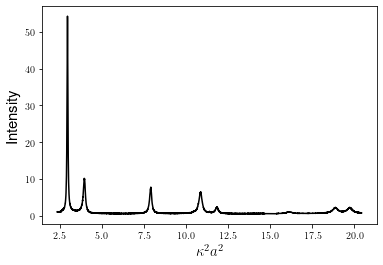

In [633]:
sample = np.loadtxt('benchmark_spectra/NiMo_sample.dat')
plt.plot(sample[:,0], sample[:,1], '-', c='black')
plt.xlabel('$\kappa^2 a^2$', fontsize = 15)
plt.ylabel('Intensity', fontsize = 15)


We aim to determine the microstructural parameters of this sample, based on the __first five__ peaks. To make the spectrum ameanable to analysis with DifFault, we carry out the following preprocessing steps

- Truncate the spectrum such that only the first five peaks are visible, i.e., $\kappa^2a^2 \in[0, 14]$. 
- Subtract the baseline, which is primarily composed of the instrumental profile. For this step, we use the ```pybaselines``` package https://pypi.org/project/pybaselines/
- Normalize the intensity values such that the first peak has magnitude 1. 
- Interpolate the processed spectrum to be uniformly sampled from the inteval $\kappa^2a^2 \in[0, 14]$.
- Set the intensity values to zero for $\kappa$ smaller than the first peak location.


In [634]:
def truncate_spectrum(kappa, intensity, domain):
    isInSpectrum = np.logical_and(kappa <= domain[1],kappa >= domain[0])
    return kappa[isInSpectrum], intensity[isInSpectrum]

In [635]:
kappa, intensity_truncated = truncate_spectrum(sample[:,0], sample[:,1], [0, 14])

In [636]:
kappas_interpolated = single_peak.positive_diffraction_vectors_dimensionless

In [637]:

from pybaselines import whittaker
from scipy import interpolate

In [638]:
def subtract_bg_arpls(x, y, bg):
    return y - bg


def preprocess_with_arpls(x, y, kappas):
    bg = whittaker.drpls(y)[0] 

    ynew = subtract_bg_arpls(x, y, bg)
    f = interpolate.interp1d(x, ynew, bounds_error = False, fill_value = 0)
    spectrum = f(kappas)
    spectrum = (spectrum) / (spectrum.max() - spectrum.min())
    return spectrum - spectrum.min()

In [639]:
true_spectrum = preprocess_with_arpls(kappa, intensity_truncated, kappas_interpolated)

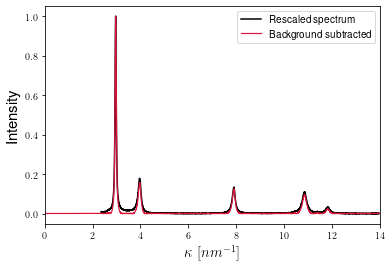

In [640]:
rescaled_sample = sample[:,1] / (sample[:,1].max() - sample[:,1].min()) 
rescaled_sample = rescaled_sample - rescaled_sample.min()
plt.plot(sample[:,0], rescaled_sample, '-', c='black', label = 'Rescaled spectrum')
plt.plot(kappas_interpolated, true_spectrum, '-', linewidth = 1.2, c='crimson', label = 'Background subtracted')
plt.xlabel('$\kappa$ $[nm^{-1}]$', fontsize = 15)
plt.ylabel('Intensity', fontsize = 15)
plt.xlim(0, 14)
plt.legend()

### Optimization

Since in this case, finding the peak positions and intensities can be done by searching for local maxima of the signal, we fix those. 

Let us set up a loss function for the optimization. Combine all variables into a single vector first.

In [641]:
def unpack_x(x):
    m, sigma, B, rho, Rstar, q = x
    return m, sigma, B, rho, Rstar, q

In [642]:
def loss(x, intensity, offset):
    m, sigma, B, rho, Rstar, q = x
    spectrum = generate_multiple_peaks(single_peak,
                                        m,
                                        sigma,
                                       rho,
                                        Rstar,
                                        q,
                                        peak_intensities=intensity,
                                       planar_fault_probability=B,
                                       offset=offset)
    return true_spectrum.ravel() - spectrum.ravel()

Specify the initial guess for the parmeters. The initial intensity and offset values are determined by picking the relative maxima of the spectrum. Based on previous studies, we define a feasible range for the microstructural parameters. The initial values are chosen from this range following a uniform distribution.

In [643]:
from scipy.signal import find_peaks
def calculate_offsets_and_intensities(x, prominence = 0.01, height = None):
    peaks, _ = find_peaks(x, prominence=prominence, height = height)
    theoretical_peaks = np.array([3, 4, 8, 11, 12])
    peak_offsets = list(kappas_interpolated[peaks] - theoretical_peaks)
    peak_intensities = list(x[peaks])
    return np.array(peak_offsets).reshape(-1,1), np.array(peak_intensities).reshape(-1,1)


In [721]:
rng = np.random.default_rng(1)
domains = {'B': [0.01, 0.2],
           'm': [40, 100.],
           'sigma': [0.1, 1.],
           'rho': [0.0005, 0.05],
           'Rstar' : [1, 30.],
           'q' : [1.5, 2.3]
          }



In [722]:
np.random.seed(3)
m_init = rng.uniform(low = domains['m'][0], high = domains['m'][1])
sigma_init = rng.uniform(low = domains['sigma'][0], high = domains['sigma'][1])
B_init = rng.uniform(low = domains['B'][0], high = domains['B'][1])
rho_init = rng.uniform(low = domains['rho'][0], high = domains['rho'][1])
Rstar_init = rng.uniform(low = domains['Rstar'][0], high = domains['Rstar'][1])
q_init = rng.uniform(low = domains['q'][0], high = domains['q'][1])
offsets, intensities = calculate_offsets_and_intensities(true_spectrum)


In [723]:
m_cmwp = 31
sigma_cmwp = 0.2
rho_cmwp = 0.025
Rstar_cmwp = 1.21
q_cmwp = 1.7
B_cmwp = 0.058

We also impose these bounds for the least squares regression. 

In [724]:
intensity_min = 0.001
intensity_max = 1.1

bounds1 = [domains['m'][0],
           domains['sigma'][0], 
           domains['B'][0],
           domains['rho'][0],
           domains['Rstar'][0],
           domains['q'][0]]
bounds2 = [domains['m'][1],
           domains['sigma'][1],
           domains['B'][1],
           domains['rho'][1],
           domains['Rstar'][1],
           domains['q'][1]]

In [725]:
x_0 = np.array([m_init, sigma_init, B_init, rho_init, Rstar_init, q_init])

In [726]:
from scipy.optimize import least_squares

In [727]:
loss_fixed_intensity_offset = lambda x : loss(x, intensities, offsets)

In [728]:
res_constrained  = least_squares(loss_fixed_intensity_offset, x_0,  ftol = 1e-12, bounds = (bounds1, bounds2),
                                     verbose = 2, jac = '2-point')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2153e-01                                    4.35e-01    
       1              2         6.6618e-02      5.49e-02       3.36e+00       6.50e-02    
       2              3         3.9478e-02      2.71e-02       1.35e+01       1.00e-01    
       3              4         3.4404e-02      5.07e-03       4.89e+00       7.76e-02    
       4              5         3.2522e-02      1.88e-03       3.33e+00       2.59e-02    
       5              6         3.1995e-02      5.27e-04       2.79e+00       2.13e-02    
       6              7         3.1894e-02      1.01e-04       1.77e+00       6.82e-03    
       7              8         3.1852e-02      4.24e-05       2.43e+00       9.57e-03    
       8              9         3.1829e-02      2.28e-05       1.36e+00       2.17e-03    
       9             10         3.1805e-02      2.34e-05       2.24e+00       6.92e-03    

In [729]:
m, sigma, B, rho, Rstar, q = unpack_x(res_constrained.x)

In [730]:
predicted_spectrum = generate_multiple_peaks(single_peak,
                                        m,
                                        sigma,
                                        rho,
                                        Rstar,
                                        q,
                                        peak_intensities = intensities,
                                        planar_fault_probability = B,
                                        offset = offsets)

In [731]:
offsets

array([[-0.03455012],
       [-0.03638139],
       [-0.08814553],
       [-0.13465999],
       [-0.18093029]])

In [732]:
theoretical_peaks = np.array([3, 4, 8, 11, 12])

In [733]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':10})
rc('text', usetex=True)

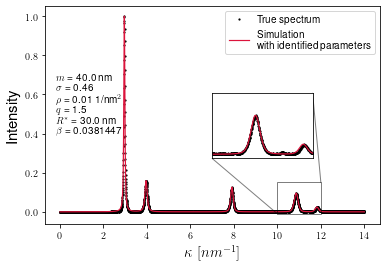

In [734]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.plot(single_peak.positive_diffraction_vectors_dimensionless, true_spectrum, 'o', markersize = 1.2, c='black', label = 'True spectrum')
ax.plot(single_peak.positive_diffraction_vectors_dimensionless, predicted_spectrum,'-',  linewidth = 1.2, c='Crimson', label = 'Simulation  \n with identified parameters')
ax.legend()

text_to_print = "$m$ = %s nm \n $\\sigma$ = %s \n $\\rho$ = %s 1/nm$^2$ \n $q$ = %s \n $R^*$ = %s nm \n $\\beta$ = %s" %(round(m,2),
                                                       round(sigma,2),
                                                      round(rho,2), 
                                                       round(q,2), 
                                                        round(Rstar, 2),
                                                       round(B, 7))#, sigma, rho, q, Rstar, B)

ax.set_xlabel('$\kappa$ $[nm^{-1}]$', fontsize = 15)
ax.set_ylabel('Intensity', fontsize = 15)

axins = ax.inset_axes(
    [0.5, 0.3, 0.3, 0.3], xticks = [], yticks = [])
axins.plot(single_peak.positive_diffraction_vectors_dimensionless, true_spectrum, 'o', markersize = 1.2, c='black', label = 'True spectrum')
axins.plot(single_peak.positive_diffraction_vectors_dimensionless, predicted_spectrum,'-',  linewidth = 1.2, c='Crimson', label = 'Simulation  \n with identified parameters')
#ax.plot(np.squeeze(theoretical_peaks + offsets.T), intensities.ravel(), 'o')
axins.set_xlim(10, 12)
#axins.set_ylim(0., 0.2)
axins.set_ylim(-0.01, 0.15)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.text(-0.2, 0.4, text_to_print)
plt.savefig('nimo_predict.pdf', bbox_inches='tight')

In [735]:
predicted_spectrum_CMWP = generate_multiple_peaks(single_peak,
                                        m_cmwp,
                                        sigma_cmwp,
                                        rho_cmwp,
                                        Rstar_cmwp,
                                        q_cmwp,
                                        peak_intensities = intensities,
                                        planar_fault_probability = B_cmwp,
                                        offset = offsets)

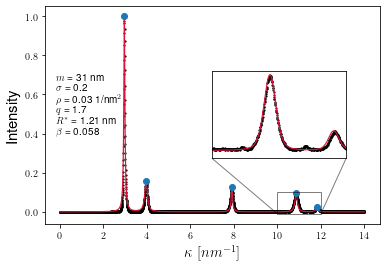

In [696]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.plot(single_peak.positive_diffraction_vectors_dimensionless, true_spectrum, 'o', markersize = 1.2, c='black', label = 'True spectrum')
ax.plot(single_peak.positive_diffraction_vectors_dimensionless, predicted_spectrum_CMWP,'-',  linewidth = 1.2, c='Crimson', label = 'Simulation  \n with identified parameters')

text_to_print = "$m$ = %s nm \n $\\sigma$ = %s \n $\\rho$ = %s 1/nm$^2$ \n $q$ = %s \n $R^*$ = %s nm \n $\\beta$ = %s" %(round(m_cmwp,2),
                                                       round(sigma_cmwp,2),
                                                      round(rho_cmwp,2), 
                                                       round(q_cmwp,2), 
                                                        round(Rstar_cmwp, 2),
                                                       round(B_cmwp, 7))#, sigma, rho, q, Rstar, B)

ax.set_xlabel('$\kappa$ $[nm^{-1}]$', fontsize = 15)
ax.set_ylabel('Intensity', fontsize = 15)

axins = ax.inset_axes(
    [0.5, 0.3, 0.4, 0.4], xticks = [], yticks = [])
axins.plot(single_peak.positive_diffraction_vectors_dimensionless, true_spectrum, 'o', markersize = 1.2, c='black', label = 'True spectrum')
axins.plot(single_peak.positive_diffraction_vectors_dimensionless, predicted_spectrum,'-',  linewidth = 1.2, c='Crimson', label = 'Simulation  \n with identified parameters')
ax.plot(np.squeeze(theoretical_peaks + offsets.T), intensities.ravel(), 'o')
axins.set_xlim(10, 12)
#axins.set_ylim(0., 0.2)
axins.set_ylim(-0.01, 0.1)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.text(-0.2, 0.4, text_to_print)
plt.savefig('nimo_predict_CMWP.pdf', bbox_inches='tight')

Text(0, 0.5, 'Error')

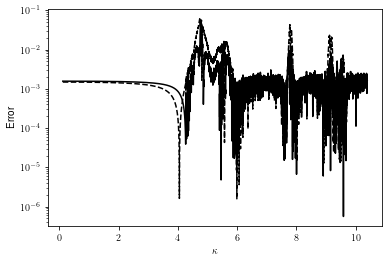

In [698]:
plt.semilogy(single_peak.positive_diffraction_vectors, np.abs(true_spectrum-predicted_spectrum.ravel()), c='black')
plt.semilogy(single_peak.positive_diffraction_vectors, np.abs(true_spectrum-predicted_spectrum_CMWP.ravel()), '--', c='black', label = 'CMWP')

plt.xlabel('$\\kappa$')
plt.ylabel('Error')
